In [1]:
import numpy as np

import torch
import torch.nn as nn

import matplotlib.pyplot as plt

np.random.seed(123)
torch.manual_seed(123)

import math
from sklearn.linear_model import LinearRegression

# Use some real data - river-dl

In [2]:
# data from Simon's ~June 2022 river-dl run
river_dl = np.load("../../../Downloads/prepped_365_1.npz", allow_pickle = True)

# Subsetting data to
#    last year of data, (last batch of 455)
#    180-day sequences (second half of the water? year)
#    first 7 input vars (redundant now)
x = torch.from_numpy(river_dl['x_trn']).float()[-455:, -180:, :7]
y = torch.from_numpy(river_dl['y_obs_trn']).float()[-455:, -180:]

adj_matrix = river_dl['dist_matrix']
batch_size = adj_matrix.shape[0]

x.shape, y.shape, adj_matrix.shape

(torch.Size([455, 180, 7]), torch.Size([455, 180, 1]), (455, 455))

# Define RGCN v1

In [3]:
## RGCN - This version follows the published version of the RGCN by Jia et al. (2020)
# https://doi.org/10.1137/1.9781611976700.69
class RGCN_v1(nn.Module):
    # Built off of https://towardsdatascience.com/building-a-lstm-by-hand-on-pytorch-59c02a4ec091
    def __init__(self, input_dim, hidden_dim, adj_matrix, recur_dropout=0, dropout=0, return_states=False, device='cpu'):
        """
        @param input_dim: [int] number input feature
        @param hidden_dim: [int] hidden size
        @param adj_matrix: Distance matrix for graph convolution
        @param recur_dropout: [float] fraction of the units to drop from the cell update vector. See: https://arxiv.org/abs/1603.05118
        @param dropout: [float] fraction of the units to drop from the input
        @param return_states: [bool] If true, returns h and c states as well as predictions
        """
        super().__init__()

        # New stuff
        self.A = torch.from_numpy(adj_matrix).float().to(device)  # provided at initialization
        # parameters for mapping graph/spatial data
        self.weight_q = nn.Parameter(torch.Tensor(hidden_dim, hidden_dim))
        self.bias_q = nn.Parameter(torch.Tensor(hidden_dim))

        self.input_dim = input_dim
        self.hidden_size = hidden_dim
        self.weight_ih = nn.Parameter(torch.Tensor(input_dim, hidden_dim * 4))
        self.weight_hh = nn.Parameter(torch.Tensor(hidden_dim, hidden_dim * 4))
        self.bias = nn.Parameter(torch.Tensor(hidden_dim * 4))
        self.init_weights()

        self.dropout = nn.Dropout(dropout)
        self.recur_dropout = nn.Dropout(recur_dropout)

        self.dense = nn.Linear(hidden_dim, 1)
        self.return_states = return_states

    def init_weights(self):
        for p in self.parameters():
            if p.data.ndimension() >= 2:
                nn.init.xavier_uniform_(p.data)
            else:
                nn.init.zeros_(p.data)

    def forward(self, x, init_states=None):
        """Assumes x is of shape (batch, sequence, feature)"""
        bs, seq_sz, _ = x.size()
        hidden_seq = []
        if init_states is None:
            h_t, c_t = (torch.zeros(bs, self.hidden_size).to(x.device),
                        torch.zeros(bs, self.hidden_size).to(x.device))
        else:
            h_t, c_t = init_states

        x = self.dropout(x)
        HS = self.hidden_size
        for t in range(seq_sz):
            x_t = x[:, t, :]
            # batch the computations into a single matrix multiplication
            gates = x_t @ self.weight_ih + h_t @ self.weight_hh + self.bias
            i_t, f_t, g_t, o_t = (
                torch.sigmoid(gates[:, :HS]),  # input
                torch.sigmoid(gates[:, HS:HS * 2]),  # forget
                torch.tanh(gates[:, HS * 2:HS * 3]),
                torch.sigmoid(gates[:, HS * 3:]),  # output
            )
            q_t = torch.tanh(h_t @ self.weight_q + self.bias_q)
            c_t = f_t * (c_t + self.A @ q_t) + i_t * self.recur_dropout(g_t)  # note: self.A @ q_t
            h_t = o_t * torch.tanh(c_t)
            hidden_seq.append(h_t.unsqueeze(1))
        hidden_seq = torch.cat(hidden_seq, dim=1)
        out = self.dense(hidden_seq)
        if self.return_states:
            return out, (h_t, c_t)
        else:
            return out
        
def rmse_masked(y_true, y_pred):
    num_y_true = torch.count_nonzero(~torch.isnan(y_true))
    if num_y_true > 0:
        zero_or_error = torch.where(
            torch.isnan(y_true), torch.zeros_like(y_true), y_pred - y_true
        )
        sum_squared_errors = torch.sum(torch.square(zero_or_error))
        rmse_loss = torch.sqrt(sum_squared_errors / num_y_true)
    else:
        rmse_loss = 0.0
    return rmse_loss

In [4]:
model = RGCN_v1(7, 20, adj_matrix)

In [5]:
loss_fn = rmse_masked
optimizer = torch.optim.Adam(model.parameters())

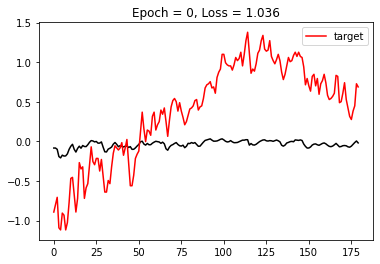

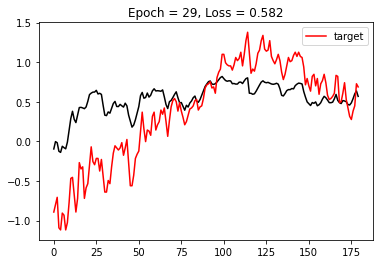

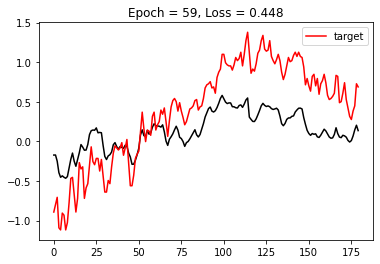

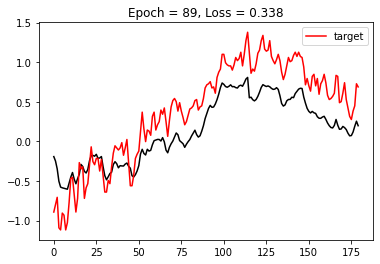

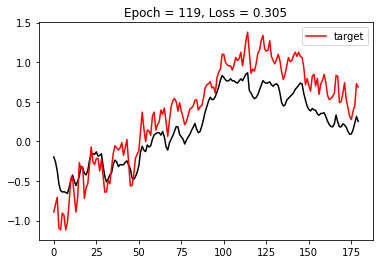

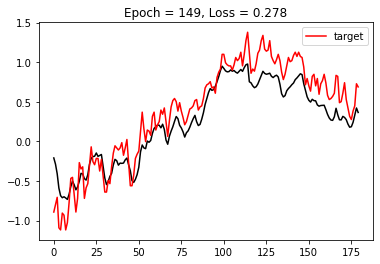

In [6]:
epochs = 150

for i in range(epochs):
    out = model(x)
    loss = loss_fn(y, out)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if (i+1) % int(epochs/5) == 0 or i == 0:
        plt.plot(out.detach()[1], color = 'black')
        plt.plot(y[-455:][1], color = 'red', label = 'target')
        plt.title('Epoch = ' + str(i) + ', Loss = ' + str(np.round(loss.item(), 3)))
        plt.legend()
        plt.pause(0.001);

# Run custom SHAP using the number of samples that the SHAP library uses

In [7]:
def weighting_kernel(M, num_nonzero_z):
    if num_nonzero_z == 0 or num_nonzero_z == M:
        out = 10000
    else:
        numerator = (M - 1)

        denom_1 = math.comb(M, num_nonzero_z)
        denom_2 = num_nonzero_z
        denom_3 = (M - num_nonzero_z)

        out = numerator / (denom_1 * denom_2 * denom_3)
    return(out)

In [8]:
x = torch.from_numpy(river_dl['x_trn']).float()[:, -180:, :7]

n_series = river_dl['x_trn'].shape[0]
n_segs = adj_matrix.shape[0]
num_vars = x.shape[2]
seq_len = x.shape[1]

x_4D = x.reshape(n_series//n_segs,n_segs,seq_len,num_vars)

In [9]:
whole_x = x_4D.clone()

In [10]:
%%time
    
    instance = -1
    x_to_explain = x_4D[instance]
        
    # defining environment variables for shaping
    num_vars = x_to_explain.shape[-1]
    n_samples = 2 * num_vars + 2048

    # structures to store random masks and associated predictions
    all_masks = np.ones([n_samples, whole_x.shape[1], whole_x.shape[2], num_vars])
    #all_preds = np.zeros([n_samples, n_segs, seq_len, 1])
    all_preds = np.zeros([n_samples, whole_x.shape[1], whole_x.shape[2], 1])
    all_weights = np.zeros([n_samples*whole_x.shape[1]*whole_x.shape[2]])

    # for many samples...
    for sample_i in range(n_samples):
        # generate a random mask for features to "remove" and store it
        mask = np.random.binomial(1, 0.5, num_vars)
        all_masks[sample_i] = mask

        ref_x = x_to_explain.numpy().copy()
        cur_x = ref_x.copy()
        # select a random year to fill removed variables with
        #rand_year = np.random.choice(22)
        rand_year = np.random.choice(whole_x.shape[0])
        cur_x[:, :, ~mask.astype(bool)] = whole_x[rand_year, :, :, ~mask.astype(bool)]

        # get associated predictions and store
        cur_y_hat = model(torch.from_numpy(cur_x).float())
        all_preds[sample_i] = cur_y_hat.detach().numpy()

        # get associated weights
        all_weights[sample_i*whole_x.shape[1]*whole_x.shape[2]:(sample_i+1)*whole_x.shape[1]*whole_x.shape[2]] = np.repeat(
            weighting_kernel(num_vars,
                             np.sum(mask)),
            whole_x.shape[1]*whole_x.shape[2]
        )
        
    linear_in = all_masks.reshape(-1, num_vars)
    linear_target = all_preds.reshape(-1, 1)

    weighted_linear_model = LinearRegression()
    weighted_linear_model.fit(linear_in, linear_target, all_weights.flatten())

Wall time: 6min 43s


LinearRegression()

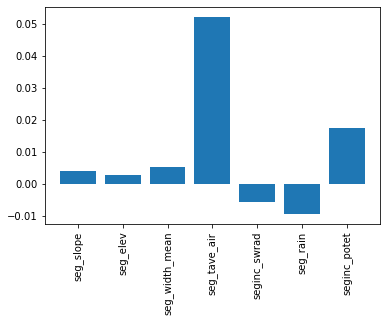

In [11]:
# feature importance lines up very closely to what Exp Grad showed
plt.bar(range(7), weighted_linear_model.coef_[0])
plt.xticks(range(7), river_dl['x_vars'], rotation = 90);

# across time

In [12]:
%%time
    instance = -1
    x_to_explain = x_4D[instance]
        
    # defining environment variables for shaping
    num_vars = x_to_explain.shape[-2] # for SHAP, not necessarily features, here temporal masking
    n_samples = 2 * num_vars + 2048

    # structures to store random masks and associated predictions
    all_masks = np.ones([n_samples, whole_x.shape[1], whole_x.shape[2]])
    #all_preds = np.zeros([n_samples, n_segs, seq_len, 1])
    all_preds = np.zeros([n_samples, whole_x.shape[1], whole_x.shape[2], 1])
    all_weights = np.zeros([n_samples*whole_x.shape[1]])

    # for many samples...
    for sample_i in range(n_samples):
        # generate a random mask for features to "remove" and store it
        mask = np.random.binomial(1, 0.5, whole_x.shape[2])
        all_masks[sample_i] = mask

        ref_x = x_to_explain.numpy().copy()
        cur_x = ref_x.copy()
        # select a random year to fill removed variables with
        #rand_year = np.random.choice(22)
        rand_year = np.random.choice(whole_x.shape[0])
        cur_x[:, ~mask.astype(bool), :] = whole_x[rand_year, :, ~mask.astype(bool), :]

        # get associated predictions and store
        cur_y_hat = model(torch.from_numpy(cur_x).float())
        all_preds[sample_i] = cur_y_hat.detach().numpy()

        # get associated weights
        all_weights[sample_i*whole_x.shape[1]:(sample_i+1)*whole_x.shape[1]] = np.repeat(
            weighting_kernel(whole_x.shape[2],
                             np.sum(mask)),
            whole_x.shape[1]
        )
        
    linear_in = all_masks.reshape(-1, whole_x.shape[2])
    linear_target = all_preds[:, :, -1, 0].reshape(-1, 1) # train the explaination model on just the last days outcome

    weighted_linear_model = LinearRegression()
    weighted_linear_model.fit(linear_in, linear_target, all_weights.flatten())

Wall time: 7min 29s


LinearRegression()

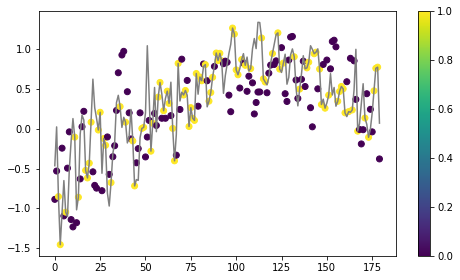

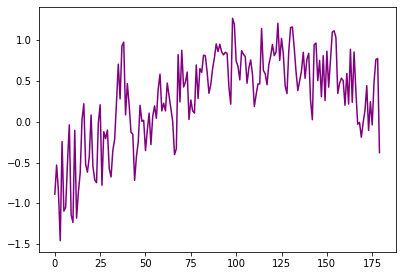

In [13]:
# for one sample, show what times were masked
plt.figure(figsize = (16/2, 9/2))
plt.plot(ref_x[0, :, 3], color = 'gray')
plt.scatter(range(180), cur_x[0, :, 3], c=mask)
plt.colorbar()
plt.pause(0.001)

plt.figure(figsize = (16/2.5, 9/2))
plt.plot(cur_x[0, :, 3], color = 'purple');

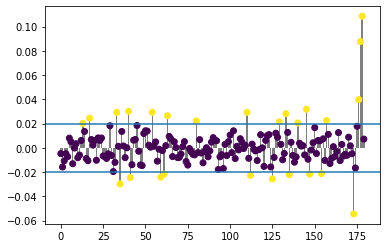

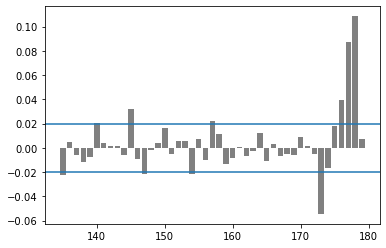

In [14]:
# plot the SHAP value for each time step
plt.bar(range(180), weighted_linear_model.coef_[0], color = 'gray')
plt.scatter(range(180), weighted_linear_model.coef_[0], c = (weighted_linear_model.coef_[0] > 0.02) + (weighted_linear_model.coef_[0] < -0.02))
plt.axhline(0.02)
plt.axhline(-0.02)

plt.pause(0.001)

plt.bar(range(180)[-45:], weighted_linear_model.coef_[0][-45:], color = 'gray')
plt.axhline(0.02)
plt.axhline(-0.02);

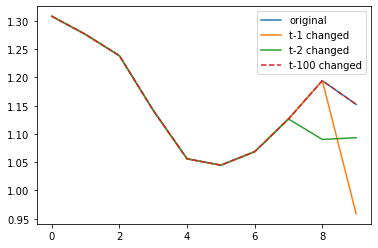

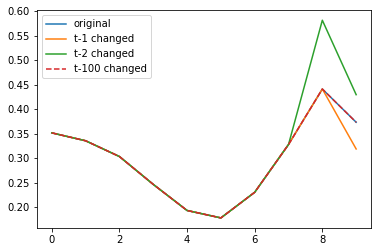

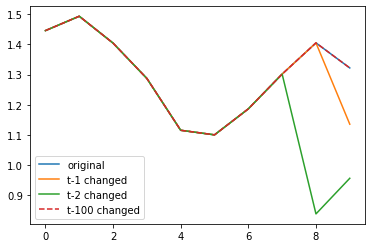

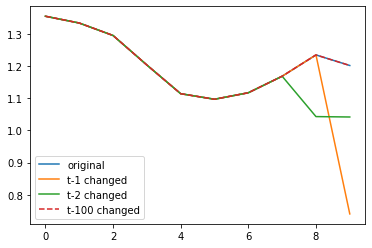

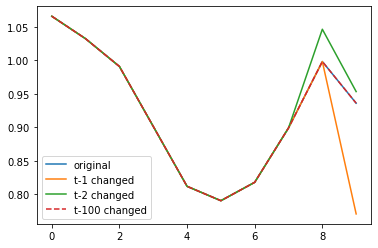

In [15]:
# SHAP values seem to claim that t-1 was not very important
# while t-2 was very important
# likewise, it would appear that t-100 is similarly important to t-1
for i in range(5):
    rand_seg = np.random.choice(455)

    ref_y = model(torch.from_numpy(ref_x).float())
    plt.plot(ref_y[rand_seg, -10:, 0].detach().numpy(), label = 'original')

    alt_x = ref_x.copy()
    alt_x[:, -1, :] = np.random.normal(size = ref_x[:, -1, :].shape)
    alt_y = model(torch.from_numpy(alt_x).float())
    plt.plot(alt_y[rand_seg, -10:, 0].detach().numpy(), label = 't-1 changed')

    alt_x = ref_x.copy()
    alt_x[:, -2, :] = np.random.normal(size = ref_x[:, -2, :].shape)
    alt_y = model(torch.from_numpy(alt_x).float())
    plt.plot(alt_y[rand_seg, -10:, 0].detach().numpy(), label = 't-2 changed')
    
    alt_x = ref_x.copy()
    alt_x[:, -100, :] = np.random.normal(size = ref_x[:, -100, :].shape)
    alt_y = model(torch.from_numpy(alt_x).float())
    plt.plot(alt_y[rand_seg, -10:, 0].detach().numpy(), label = 't-100 changed', linestyle = '--')

    plt.legend()
    plt.pause(0.001);
# permutation based experiments do not agree very well

# Across space

In [16]:
%%time
    instance = -1
    x_to_explain = x_4D[instance]
        
    # defining environment variables for shaping
    num_vars = x_to_explain.shape[-3] # for SHAP, not necessarily features, here spatial masking
    n_samples = 2 * num_vars + 2048

    # structures to store random masks and associated predictions
    all_masks = np.ones([n_samples, whole_x.shape[2], whole_x.shape[1]])
    #all_preds = np.zeros([n_samples, n_segs, seq_len, 1])
    all_preds = np.zeros([n_samples, whole_x.shape[1], whole_x.shape[2], 1])
    all_weights = np.zeros([n_samples*whole_x.shape[2]])

    # for many samples...
    for sample_i in range(n_samples):
        # generate a random mask for features to "remove" and store it
        mask = np.random.binomial(1, 0.5, whole_x.shape[1])
        all_masks[sample_i] = mask

        ref_x = x_to_explain.numpy().copy()
        cur_x = ref_x.copy()
        # select a random year to fill removed variables with
        #rand_year = np.random.choice(22)
        rand_year = np.random.choice(whole_x.shape[0])
        cur_x[~mask.astype(bool), :, :] = whole_x[rand_year, ~mask.astype(bool), :, :]

        # get associated predictions and store
        cur_y_hat = model(torch.from_numpy(cur_x).float())
        all_preds[sample_i] = cur_y_hat.detach().numpy()

        # get associated weights
        all_weights[sample_i*whole_x.shape[2]:(sample_i+1)*whole_x.shape[2]] = np.repeat(
            weighting_kernel(whole_x.shape[1],
                             np.sum(mask)),
            whole_x.shape[2]
        )
        
    linear_in = all_masks.reshape(-1, whole_x.shape[1])
    linear_target = all_preds[:, 0, :, 0].reshape(-1, 1) # train the explanation model on just the 0th segment outcomes

    weighted_linear_model = LinearRegression()
    weighted_linear_model.fit(linear_in, linear_target, all_weights.flatten())

Wall time: 10min 43s


LinearRegression()

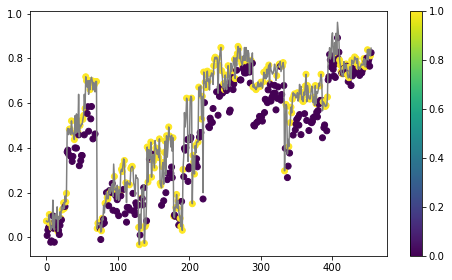

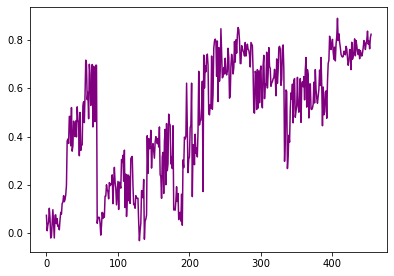

In [17]:
# showing what segments were masked at the last sample
plt.figure(figsize = (16/2, 9/2))
plt.plot(ref_x[:, -1, 3], color = 'gray')
plt.scatter(range(455), cur_x[:, -1, 3], c=mask)
plt.colorbar()
plt.pause(0.001)

plt.figure(figsize = (16/2.5, 9/2))
plt.plot(cur_x[:, -1, 3], color = 'purple');

<BarContainer object of 455 artists>

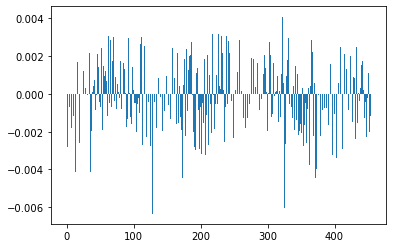

In [18]:
plt.bar(range(455), weighted_linear_model.coef_[0])

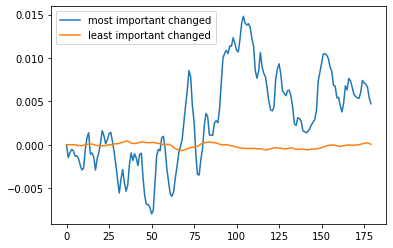

In [19]:
    alt_x = ref_x.copy()
    alt_x[np.argmax(weighted_linear_model.coef_[0]), :, :] = np.random.normal(size = ref_x[np.argmax(weighted_linear_model.coef_[0]), :, :].shape)
    alt_y = model(torch.from_numpy(alt_x).float())
    plt.plot(ref_y[0, :, 0].detach().numpy() - alt_y[0, :, 0].detach().numpy(), label = 'most important changed')
    
    alt_x = ref_x.copy()
    alt_x[np.argmin(weighted_linear_model.coef_[0]), :, :] = np.random.normal(size = ref_x[np.argmin(weighted_linear_model.coef_[0]), :, :].shape)
    alt_y = model(torch.from_numpy(alt_x).float())
    plt.plot(ref_y[0, :, 0].detach().numpy() - alt_y[0, :, 0].detach().numpy(), label = 'least important changed')
    
    plt.legend()

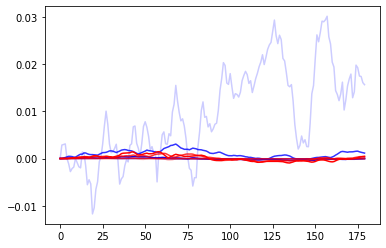

In [20]:
alpha = 1
for index in np.argsort(weighted_linear_model.coef_[0])[-5:]:
    alt_x = ref_x.copy()
    alt_x[index, :, :] = 10*np.random.normal(size = ref_x[index, :, :].shape)
    alt_y = model(torch.from_numpy(alt_x).float())
    plt.plot(ref_y[0, :, 0].detach().numpy() - alt_y[0, :, 0].detach().numpy(), label = 'most important changed', color = 'blue', alpha = alpha)
    alpha += -0.2
    
alpha = 1
for index in np.argsort(weighted_linear_model.coef_[0])[:5]:
    alt_x = ref_x.copy()
    alt_x[index, :, :] = 10*np.random.normal(size = ref_x[index, :, :].shape)
    alt_y = model(torch.from_numpy(alt_x).float())
    plt.plot(ref_y[0, :, 0].detach().numpy() - alt_y[0, :, 0].detach().numpy(), label = 'least important changed', color = 'red', alpha = alpha)
    alpha += -0.2
# in general, these seem to often agree with permutation experiments but not as closely as Exp Grad